# eBike Trips

- Predict available bicycle capacity over the next 30-90 minutes so this data can be made available to customers on the app.

- Key part of this is to predict the duration of the bike trips (time picked up to time returned)

- We have 3 datasets to help with this task
    1. bike docking stations
    2. Historical trips
    3. Weather

## Approach

**Step 1: Prepare the dataset**

    Use the three datasets and use a series of joins to make one dataset which gives all relevant information on  historical trips, along with information on the docking station the bike is collected from and the weather.

    Make use of feature engineering to create any additional features that may be useful in order to gain better understanding and make more sense within the context of the problem.


**Step 2: Exploratory Data Analysis**

    Look into the data and see if there are any data quality issues that need to be addressed or combated, look into the distribution of the data and it's correlation with the target variable

**Step 3: Prepare the Dataset for Training**

    Prepare the dataset to be passed into a model for training, splitting into a training and test set, one-hot-encoding any columns that may require, and drop any columns that are too highly correlated.

**Step 4: Train and Evaluate an ML Model**

    Fit the data into a sklearn regression model (as this is a regression problem).

    Evaluate the results using metrics (e.g. MSE and R2) - testing both the training and test set to check for overfitting.

    Look into improvements on the model:
    - cross validation for overfitting
    - hyper-parameter tuning
    - testing out different models (e.g. SVM or Random Forrest Regressor)

### Imports:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold

## Loading and Preparing the Dataset

Here I load in the dataset in the form of 3 separate csv files, I will merge it and put it all into a singular dataframe. Finally I will remove the collums that I will not need for training.

Loading in the dataset as dataframes

In [5]:
stations_df = pd.read_csv('data/hubway_stations.csv')
stations_df

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing
...,...,...,...,...,...,...,...
137,141,S32008,Powder House Circle,Somerville,42.400877,-71.116772,Existing
138,142,S32009,Packard Ave / Powderhouse Blvd,Somerville,42.404490,-71.123413,Existing
139,143,S32010,Somerville Hospital at Highland Ave / Crocker St,Somerville,42.390820,-71.109420,Existing
140,144,S32011,Teele Square at 239 Holland St,Somerville,42.402763,-71.126908,Existing


In [6]:
trips_df = pd.read_csv('data/hubway_trips.csv')
trips_df

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,Closed,720,11/30/2013 23:30:00,130.0,11/30/2013 23:42:00,90.0,T01341,Registered,'02141,NaN,Male
1579021,1579022,1748019,Closed,480,11/30/2013 23:32:00,67.0,11/30/2013 23:40:00,88.0,T01328,Registered,'02143,NaN,Male
1579022,1579023,1748020,Closed,540,11/30/2013 23:32:00,137.0,11/30/2013 23:41:00,133.0,T01310,Casual,NaN,NaN,NaN
1579023,1579024,1748021,Closed,120,11/30/2013 23:36:00,76.0,11/30/2013 23:38:00,68.0,B01478,Registered,'02141,NaN,Male


In [7]:
weather_df = pd.read_csv('data/weather.csv')
weather_df

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,
...,...,...,...,...,...,...,...,...,...
2649,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 15:00,0.03,,
2650,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 16:00,0.35,,
2651,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 17:00,0.19,,
2652,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 18:00,0.00,T,


### Merging the Datasets into trips_df

I now want to combine the datasets so that we have one dataset which can be used for the trips, so I will add the weather and station data onto the trips dataset for each instance of trip

In [8]:
# Joining trips and stations on "id" and "strt_statn"
trips_df = trips_df.drop(columns=["status"])
trips_df = trips_df.merge(stations_df, left_on="strt_statn", right_on="id", how="left")
trips_df

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,id,terminal,station,municipal,lat,lng,status
0,1,8,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
1,2,9,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
2,3,10,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
3,4,11,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
4,5,12,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,720,11/30/2013 23:30:00,130.0,11/30/2013 23:42:00,90.0,T01341,Registered,'02141,NaN,Male,130.0,M32021,Harvard University Gund Hall at Quincy St / Ki...,Cambridge,42.376369,-71.114025,Existing
1579021,1579022,1748019,480,11/30/2013 23:32:00,67.0,11/30/2013 23:40:00,88.0,T01328,Registered,'02143,NaN,Male,67.0,M32006,MIT at Mass Ave / Amherst St,Cambridge,42.358100,-71.093198,Existing
1579022,1579023,1748020,540,11/30/2013 23:32:00,137.0,11/30/2013 23:41:00,133.0,T01310,Casual,NaN,NaN,NaN,137.0,M32029,Porter Square Station,Cambridge,42.387995,-71.119084,Existing
1579023,1579024,1748021,120,11/30/2013 23:36:00,76.0,11/30/2013 23:38:00,68.0,B01478,Registered,'02141,NaN,Male,76.0,M32012,Central Sq Post Office / Cambridge City Hall a...,Cambridge,42.366426,-71.105495,Existing


In [9]:
trips_df.columns

Index(['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'id', 'terminal', 'station', 'municipal', 'lat',
       'lng', 'status'],
      dtype='object')

In [10]:
weather_df.head(5)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,


In [11]:
# Putting all the date/times in a standard format
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"], format="%Y%m%d %H:%M")
trips_df["start_date"] = pd.to_datetime(trips_df["start_date"], format="%m/%d/%Y %H:%M:%S")
trips_df["end_date"] = pd.to_datetime(trips_df["end_date"], format="%m/%d/%Y %H:%M:%S")

In [12]:
trips_df = trips_df.sort_values('start_date')

In [13]:
trips_df = pd.merge_asof(trips_df, weather_df, left_on='start_date', right_on='DATE', direction='forward')
trips_df

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,...,status,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,1,8,9,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,B00468,Registered,'97217,...,Removed,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,2011-07-29 09:00:00,0.0,T,
1,2,9,220,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,B00554,Registered,'02215,...,Removed,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,2011-07-29 09:00:00,0.0,T,
2,3,10,56,2011-07-28 10:33:00,23.0,2011-07-28 10:34:00,23.0,B00456,Registered,'02108,...,Removed,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,2011-07-29 09:00:00,0.0,T,
3,4,11,64,2011-07-28 10:35:00,23.0,2011-07-28 10:36:00,23.0,B00554,Registered,'02116,...,Removed,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,2011-07-29 09:00:00,0.0,T,
4,5,12,12,2011-07-28 10:37:00,23.0,2011-07-28 10:37:00,23.0,B00554,Registered,'97214,...,Removed,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,2011-07-29 09:00:00,0.0,T,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,720,2013-11-30 23:30:00,130.0,2013-11-30 23:42:00,90.0,T01341,Registered,'02141,...,Existing,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1579021,1579022,1748019,480,2013-11-30 23:32:00,67.0,2013-11-30 23:40:00,88.0,T01328,Registered,'02143,...,Existing,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1579022,1579023,1748020,540,2013-11-30 23:32:00,137.0,2013-11-30 23:41:00,133.0,T01310,Casual,NaN,...,Existing,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1579023,1579024,1748021,120,2013-11-30 23:36:00,76.0,2013-11-30 23:38:00,68.0,B01478,Registered,'02141,...,Existing,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [14]:
columns_to_drop = [
    'seq_id',          
    'hubway_id',       
    'id',            
    'bike_nr',         
    'terminal',        
    'station',       
    'STATION',        
    'STATION_NAME',     
    'Measurement_Flag', 
    'Quality_Flag',     
    'LATITUDE',      
    'LONGITUDE',  
    'DATE',
    'zip_code'            
]

trips_df = trips_df.drop(columns=columns_to_drop, errors='ignore')  # ignore in case some columns are already missing

trips_df.columns

Index(['duration', 'start_date', 'strt_statn', 'end_date', 'end_statn',
       'subsc_type', 'birth_date', 'gender', 'municipal', 'lat', 'lng',
       'status', 'ELEVATION', 'HPCP'],
      dtype='object')

# Cleaning The Data

Here I am going to check the quality of the data and clean the dataset where necessary

I will look for:
- duplicates
- missing data
- anomalies / negative values

There are further methods I could use for cleaning the data such as data imputation and using methods to check further and combat them, so this could be explored if given more time.
I could
- check for any inconsistencies with types
- check for inconsistent / incorrect time values
- etc.

At this point I am checking that the data makes sense and will remove any 'dirty' records

In [15]:
print("Number of Duplicates:",trips_df.duplicated().sum())
trips_df = trips_df.drop_duplicates()

Number of Duplicates: 37554


In [16]:
trips_df.isnull().sum()

duration            0
start_date          0
strt_statn         14
end_date            0
end_statn          45
subsc_type          0
birth_date    1190846
gender         439973
municipal          14
lat                14
lng                14
status             14
ELEVATION      517272
HPCP           517272
dtype: int64

In [17]:
# Dropping all rows where there is no end station as it may mean those journeys are incomplete
trips_df = trips_df.dropna(subset=['end_statn'])
trips_df.isnull().sum()

duration            0
start_date          0
strt_statn          7
end_date            0
end_statn           0
subsc_type          0
birth_date    1190824
gender         439954
municipal           7
lat                 7
lng                 7
status              7
ELEVATION      517272
HPCP           517272
dtype: int64

In [18]:
trips_df = trips_df.dropna(subset=['strt_statn'])
trips_df.isnull().sum()

duration            0
start_date          0
strt_statn          0
end_date            0
end_statn           0
subsc_type          0
birth_date    1190823
gender         439954
municipal           0
lat                 0
lng                 0
status              0
ELEVATION      517272
HPCP           517272
dtype: int64

In [19]:
# Could see there were negative values for duration - so using the absolute value
trips_df['duration'] = trips_df['duration'].abs()

### Feature Engineering

In [20]:
# Changing birth_date to age (note the documentation says this data is from 2013 so basing off age then)
trips_df['age'] = 2013 - trips_df['birth_date']
trips_df = trips_df.drop(columns=["birth_date"])

In [21]:
# Changing start_date to be hour of the day, day of week, month and is_weekend -  as these are more useful features to train a model
trips_df['hour'] = trips_df['start_date'].dt.hour
trips_df['dayofweek'] = trips_df['start_date'].dt.dayofweek
trips_df['month'] = trips_df['start_date'].dt.month
trips_df['is_weekend'] = trips_df['dayofweek'].isin([5, 6]).astype(int)

trips_df = trips_df.drop(columns=["start_date", "end_date"])

In [22]:
# Define conditions for categorization
conditions = [
    (trips_df['HPCP'] == 0.0),             # No rain
    (trips_df['HPCP'] > 0.0) & (trips_df['HPCP'] <= 0.5),  # Light rain
    (trips_df['HPCP'] > 0.5)               # Heavy rain
]

# Define corresponding labels
categories = ['no_rain', 'light_rain', 'heavy_rain']

trips_df['Rain_Category'] = np.select(conditions, categories, default='no_rain')
trips_df = trips_df.drop(columns=["HPCP"])

In [23]:
trips_df

,duration,strt_statn,end_statn,subsc_type,gender,municipal,lat,lng,status,ELEVATION,age,hour,dayofweek,month,is_weekend,Rain_Category
0,9,23.0,23.0,Registered,Male,Boston,42.359677,-71.059364,Removed,3.7,37.0,10,3,7,0,no_rain
1,220,23.0,23.0,Registered,Male,Boston,42.359677,-71.059364,Removed,3.7,47.0,10,3,7,0,no_rain
2,56,23.0,23.0,Registered,Male,Boston,42.359677,-71.059364,Removed,3.7,70.0,10,3,7,0,no_rain
3,64,23.0,23.0,Registered,Female,Boston,42.359677,-71.059364,Removed,3.7,32.0,10,3,7,0,no_rain
4,12,23.0,23.0,Registered,Female,Boston,42.359677,-71.059364,Removed,3.7,30.0,10,3,7,0,no_rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,130.0,90.0,Registered,Male,Cambridge,42.376369,-71.114025,Existing,NaN,NaN,23,5,11,1,no_rain
1579021,480,67.0,88.0,Registered,Male,Cambridge,42.358100,-71.093198,Existing,NaN,NaN,23,5,11,1,no_rain
1579022,540,137.0,133.0,Casual,NaN,Cambridge,42.387995,-71.119084,Existing,NaN,NaN,23,5,11,1,no_rain
1579023,120,76.0,68.0,Registered,Male,Cambridge,42.366426,-71.105495,Existing,NaN,NaN,23,5,11,1,no_rain


In [24]:
coords = trips_df[['lat', 'lng']].dropna()
kmeans = KMeans(n_clusters=10, random_state=42)
trips_df['start_cluster'] = kmeans.fit_predict(coords)

trips_df = trips_df.drop(columns=['lat', 'lng','strt_statn', 'end_statn'])

In [25]:
trips_df.isnull().sum()

duration               0
subsc_type             0
gender            439954
municipal              0
status                 0
ELEVATION         517272
age              1190823
hour                   0
dayofweek              0
month                  0
is_weekend             0
Rain_Category          0
start_cluster          0
dtype: int64

### One Hot Encoding


In [26]:
categorical_columns = ['Rain_Category', 'subsc_type', 'municipal', 'gender', 'status']
onehot = pd.get_dummies(trips_df[categorical_columns])

In [27]:
onehot = onehot.astype(int)
trips_df = trips_df.drop(categorical_columns, axis=1)
trips_df = pd.concat([trips_df, onehot], axis=1)
trips_df

,duration,ELEVATION,age,hour,dayofweek,month,is_weekend,start_cluster,Rain_Category_heavy_rain,Rain_Category_light_rain,...,subsc_type_Casual,subsc_type_Registered,municipal_Boston,municipal_Brookline,municipal_Cambridge,municipal_Somerville,gender_Female,gender_Male,status_Existing,status_Removed
0,9,3.7,37.0,10,3,7,0,5,0,0,...,0,1,1,0,0,0,0,1,0,1
1,220,3.7,47.0,10,3,7,0,5,0,0,...,0,1,1,0,0,0,0,1,0,1
2,56,3.7,70.0,10,3,7,0,5,0,0,...,0,1,1,0,0,0,0,1,0,1
3,64,3.7,32.0,10,3,7,0,5,0,0,...,0,1,1,0,0,0,1,0,0,1
4,12,3.7,30.0,10,3,7,0,5,0,0,...,0,1,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,NaN,NaN,23,5,11,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
1579021,480,NaN,NaN,23,5,11,1,9,0,0,...,0,1,0,0,1,0,0,1,1,0
1579022,540,NaN,NaN,23,5,11,1,6,0,0,...,1,0,0,0,1,0,0,0,1,0
1579023,120,NaN,NaN,23,5,11,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0


### Data Imputation

In [28]:
age_imputer = SimpleImputer(strategy='median')
trips_df['age'] = age_imputer.fit_transform(trips_df[['age']])

elevation_imputer = SimpleImputer(strategy='mean')
trips_df['ELEVATION'] = elevation_imputer.fit_transform(trips_df[['ELEVATION']])

### Finding and Removing Outliers

In [29]:
"""X = trips_df.values
nbrs = NearestNeighbors(n_neighbors = 3)
nbrs.fit(X)"""

'X = trips_df.values\nnbrs = NearestNeighbors(n_neighbors = 3)\nnbrs.fit(X)'

In [30]:
"""distances, indexes = nbrs.kneighbors(X)
plt.plot(distances.mean(axis =1))"""

'distances, indexes = nbrs.kneighbors(X)\nplt.plot(distances.mean(axis =1))'

In [31]:
trips_df.dtypes

duration                      int64
ELEVATION                   float64
age                         float64
hour                          int32
dayofweek                     int32
month                         int32
is_weekend                    int64
start_cluster                 int32
Rain_Category_heavy_rain      int64
Rain_Category_light_rain      int64
Rain_Category_no_rain         int64
subsc_type_Casual             int64
subsc_type_Registered         int64
municipal_Boston              int64
municipal_Brookline           int64
municipal_Cambridge           int64
municipal_Somerville          int64
gender_Female                 int64
gender_Male                   int64
status_Existing               int64
status_Removed                int64
dtype: object

**Using an Isolation Forest to do Anomaly Detection...**

Works by randomly splitting the data into smaller and smaller groups (like making decision trees) — and since anomalies are different and rare, they get isolated quickly, in fewer steps than normal points.

In [ ]:
# Columns to consider for anomaly detection
features_for_anomaly_detection = ['duration', 'age', 'ELEVATION']  # adjust as needed

# Ensure there are no NaNs in those columns
df_filtered = trips_df[features_for_anomaly_detection].dropna()

# Fit the Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)  # 1% anomalies
df_filtered['anomaly'] = iso_forest.fit_predict(df_filtered)

# anomaly == -1 means it’s an outlier
outliers_removed_df = trips_df[df_filtered['anomaly'] == 1]

print(f"Original shape: {trips_df.shape}")
print(f"After removing outliers: {outliers_removed_df.shape}")

Original shape: (1541419, 21)
After removing outliers: (1526205, 21)


In [33]:
trips_df = outliers_removed_df

## Preparing the Data for Training

<Axes: >

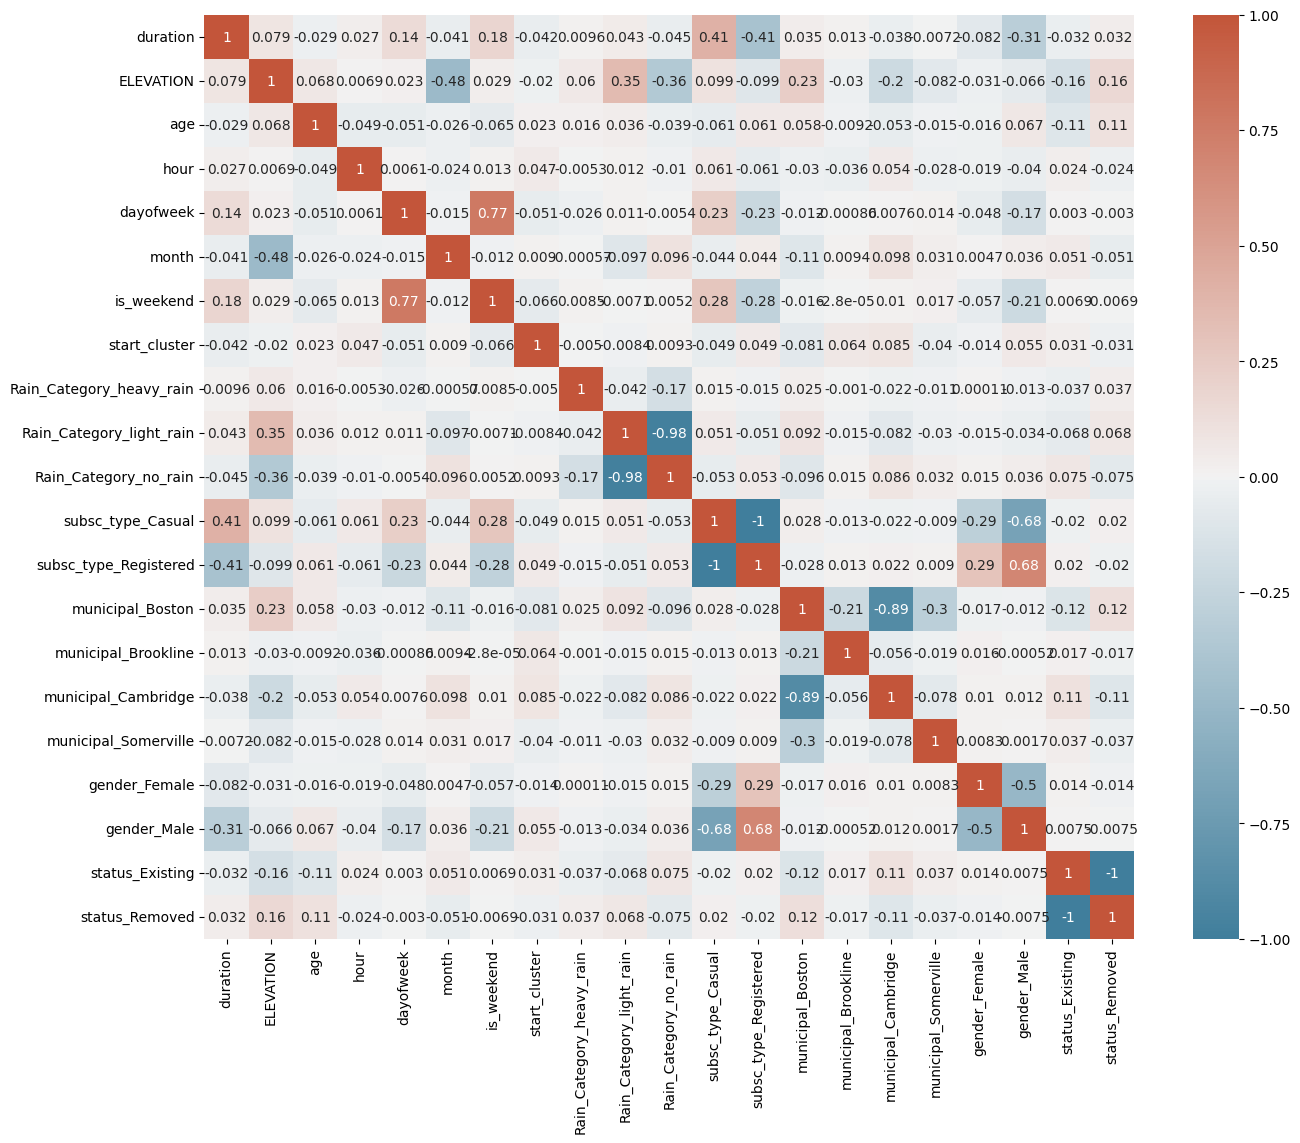

In [34]:
# Plotting a correlation matrix
cor_column = set()

corr = trips_df.corr(method='pearson')

f, ax = plt.subplots(figsize=(15,12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap)

Correlation with 'duration':
duration                    1.000000
subsc_type_Casual           0.410317
is_weekend                  0.180462
dayofweek                   0.142892
ELEVATION                   0.078778
Rain_Category_light_rain    0.043255
municipal_Boston            0.034912
status_Removed              0.032380
hour                        0.027463
municipal_Brookline         0.012517
Rain_Category_heavy_rain    0.009615
municipal_Somerville       -0.007158
age                        -0.029033
status_Existing            -0.032380
municipal_Cambridge        -0.038173
month                      -0.040866
start_cluster              -0.041882
Rain_Category_no_rain      -0.044692
gender_Female              -0.082161
gender_Male                -0.308405
subsc_type_Registered      -0.410317
Name: duration, dtype: float64


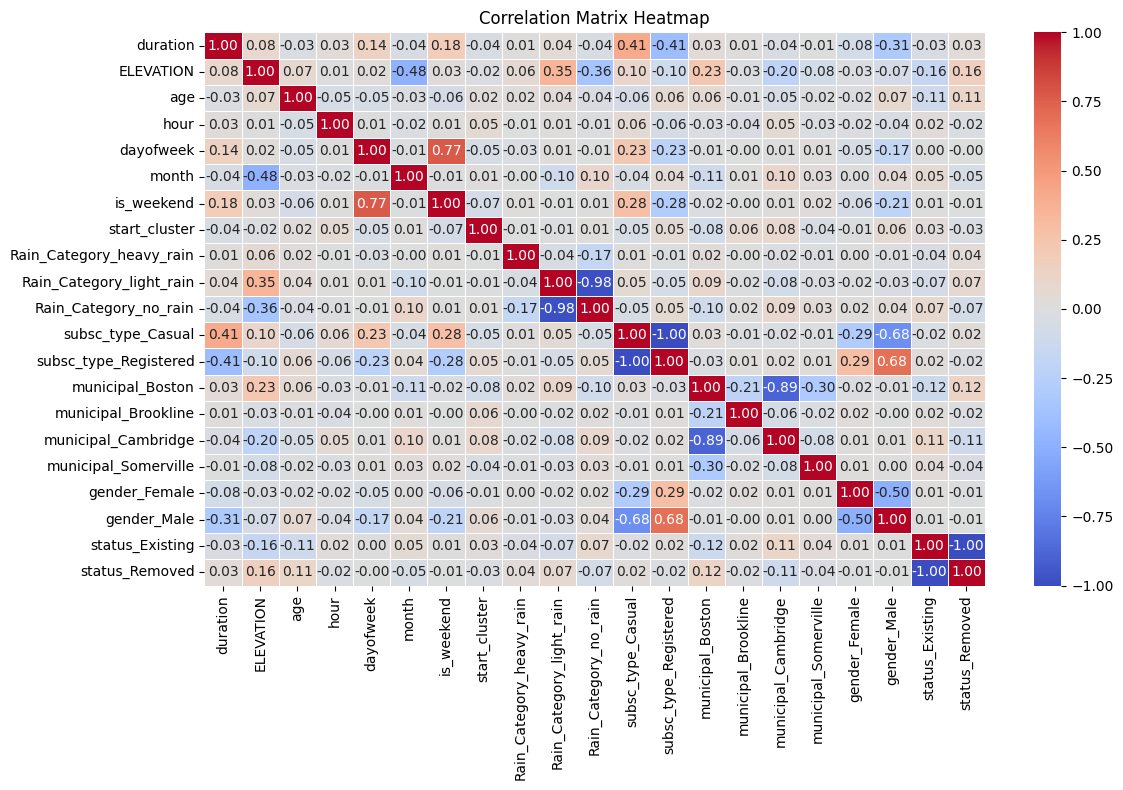

In [35]:
# Calculate Correlations
correlation_matrix = trips_df.corr(numeric_only=True)

# Show alpl correlation with 'duration' (i.e. target column)
print("Correlation with 'duration':")
print(correlation_matrix['duration'].sort_values(ascending=False))

# Correlation Matrix heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [36]:
# Making a list of all columns that are too strongly correlated ( > +-75 )
for i in range (len(corr.columns)):
  for j in range (i):
    if abs(corr.iloc[i,j]) > 0.75:
      colname = corr.columns[i]
      cor_column.add(colname)

cor_column

{'Rain_Category_no_rain',
 'is_weekend',
 'municipal_Cambridge',
 'status_Removed',
 'subsc_type_Registered'}

In [37]:
df = trips_df.drop(cor_column, axis=1)
df

,duration,ELEVATION,age,hour,dayofweek,month,start_cluster,Rain_Category_heavy_rain,Rain_Category_light_rain,subsc_type_Casual,municipal_Boston,municipal_Brookline,municipal_Somerville,gender_Female,gender_Male,status_Existing
0,9,3.7,37.0,10,3,7,5,0,0,0,1,0,0,0,1,0
1,220,3.7,47.0,10,3,7,5,0,0,0,1,0,0,0,1,0
3,64,3.7,32.0,10,3,7,5,0,0,0,1,0,0,1,0,0
4,12,3.7,30.0,10,3,7,5,0,0,0,1,0,0,1,0,0
6,24,3.7,42.0,10,3,7,5,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,3.7,34.0,23,5,11,0,0,0,0,0,0,0,0,1,1
1579021,480,3.7,34.0,23,5,11,9,0,0,0,0,0,0,0,1,1
1579022,540,3.7,34.0,23,5,11,6,0,0,1,0,0,0,0,0,1
1579023,120,3.7,34.0,23,5,11,0,0,0,0,0,0,0,0,1,1


### Splitting Data into Test and Training Set

In [38]:
data = df.values
labels = df['duration'].values

In [39]:
data_train, data_test, labels_train, labels_test = (train_test_split(data, labels,test_size = 0.33,random_state = 10))

## Training an XGBoost Model

In [40]:
#  Hyper parameter tuning
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

In [41]:
# Initialize the base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [42]:
# Fit to training data
random_search.fit(data_train, labels_train)

# Use the best model
model = random_search.best_estimator_

print("Best Parameters Found:\n", random_search.best_params_)

# === Predictions ===
train_predictions = model.predict(data_train)
test_predictions = model.predict(data_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


Best Parameters Found:
 {'colsample_bytree': np.float64(0.935552788417904), 'learning_rate': np.float64(0.04993475643167195), 'max_depth': 9, 'n_estimators': 163, 'subsample': np.float64(0.8400288679743939)}


In [43]:
# Set up K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# cross-validation with scoring (e.g., negative MAE)
scores = cross_val_score(model, data_test, labels_test, cv=kfold, scoring='neg_mean_absolute_error')

# average MAE
print("Cross-validated MAE scores:", -scores)
print("Average MAE:", round(-scores.mean(), 3))
print("Standard deviation:", round(scores.std(), 3))

Cross-validated MAE scores: [13.6186676  13.49629974 13.40564156 13.30645752 13.43885231]
Average MAE: 13.453
Standard deviation: 0.103


In [44]:
def displayPredictions(model):
   # Make predictions on the training and test set
    train_predictions = model.predict(data_train)
    test_predictions = model.predict(data_test)

    # metrics for the training set
    print("TRAINING SET METRICS")
    print("====================")
    print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_train, train_predictions), 2))
    print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_train, train_predictions), 2))
    print("R-squared:", round(sm.r2_score(labels_train, train_predictions), 2))

    # Residuals for training set
    residuals_train = labels_train - train_predictions
    print("\nResiduals:", residuals_train)
    plt.scatter(train_predictions, residuals_train)
    plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values (Training Set)")
    plt.show()


    # metrics for the test set
    print("TEST SET METRICS")
    print("====================")
    print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_test, test_predictions), 2))
    print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_test, test_predictions), 2))
    print("R-squared:", round(sm.r2_score(labels_test, test_predictions), 2))

    # Residuals for test set
    residuals_test = labels_test - test_predictions
    print("\nResiduals:", residuals_test)
    plt.scatter(test_predictions, residuals_test)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted Values (Test Set)")
    plt.show()

TRAINING SET METRICS
Mean Absolute Error (MAE): 12.17
Mean Squared Error (MSE): 4179.39
R-squared: 1.0

Residuals: [-0.60464478 -2.44647217 -1.15527344 ...  2.01454163  0.49246216
 -1.70718384]


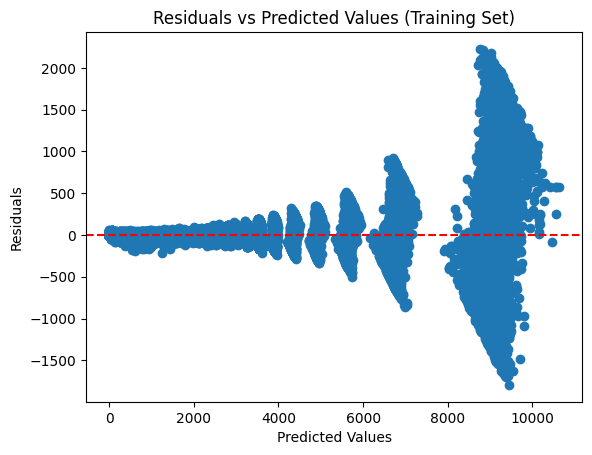

TEST SET METRICS
Mean Absolute Error (MAE): 13.07
Mean Squared Error (MSE): 5263.82
R-squared: 0.99

Residuals: [-31.20532227  16.8458252  -12.90124702 ...   1.72932434   1.48681641
   2.68450928]


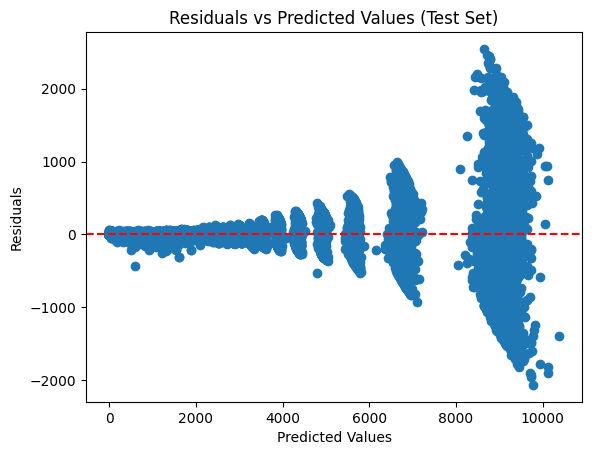

In [46]:
displayPredictions(model)

Using a Random Forrest Regressor rather than XGBoost

In [47]:
model_rf = RandomForestRegressor()
model_rf.fit(data_train, labels_train)

RandomForestRegressor()

TRAINING SET METRICS
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.0
R-squared: 1.0

Residuals: [0. 0. 0. ... 0. 0. 0.]


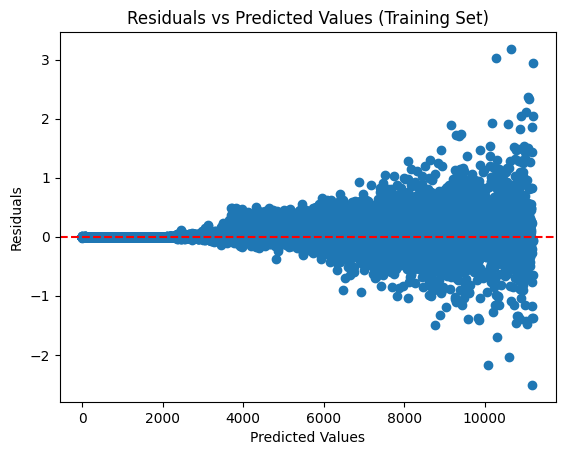

TEST SET METRICS
Mean Absolute Error (MAE): 0.0
Mean Squared Error (MSE): 0.01
R-squared: 1.0

Residuals: [0. 0. 0. ... 0. 0. 0.]


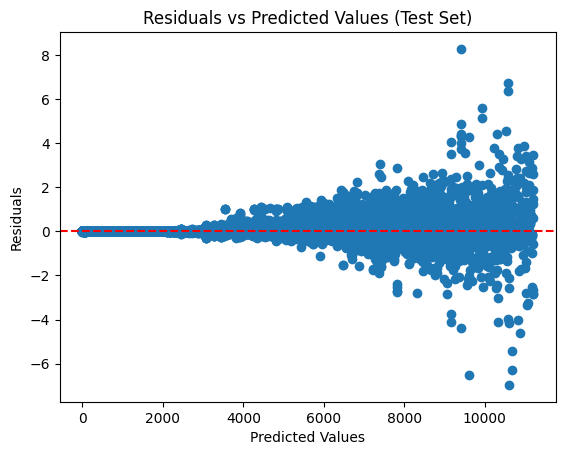

In [48]:
displayPredictions(model_rf)